# Impact Classifier

The project proposes to leverage machine learning (ML) and natural language processing (NLP) techniques to build a text classifier that automatizes the processing and identification of evidence of social impact in research documents. The proposal aims to solve a classification problem in which the model takes a sentence contained in a research document as input and produces as output a binary answer (1=True, 0=False) that states whether the sentence contains or not evidence of social impact, respectively.

From all research fields, this project focuses on Medical, Health, and Biological science because the ultimately goal is to understand the social impact of the research projects of the Spanish National Institue of Bioinformatics (INB by its Spanish Acronym), which is an institution that conducts medical and biological investigations.

The goal of this notebook is to develop a machine learning classifier able to automatically identify sentences of social impact in research documents.

## Load libraries

In [1]:
import glob
import numpy as np
import nltk
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import sys
import joblib
import json
import pickle
import seaborn as sns


nltk.download("stopwords")
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, GridSearchCV, learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

from bs4 import BeautifulSoup
from data_processor import sentence_to_words, extract_BoW_features
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/Life/jsaldiva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/Life/jsaldiva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/Life/jsaldiva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/Life/jsaldiva/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load data

### Impact sentences

Load dataset that sentences with evidence of social impact. The dataset was manually built through a process that is explain in the notebook **`0.dataset_preparation.ipynb`**.

In [2]:
impact_sentences = pd.read_csv("data/sentences/impact_sentences.csv", usecols=['sentence'])

#### Add label column

Sentences with evidence of social will later be merged with more general sentences that can be commonly found in research documents. By the time the merge occurs, social impact sentences need to be distinguised from the more general sentences. Therefore, a the new column **`label`** is created in the impact dataset to tag with 1 all sentences that contain evidence of social impact.  

In [3]:
impact_sentences['label'] = 1

In [4]:
nrows = impact_sentences.shape[0]
ncols = impact_sentences.shape[1]
print(f"The dataset contains {nrows} rows and {ncols} columns")

The dataset contains 206 rows and 2 columns


Let's show an sample of impact sentences together with the newly created column label.

In [5]:
impact_sentences.head()

,sentence,label
0,widely featured in the national press and rad...,1
1,indeed one of these projects has been select...,1
2,impact public engagement and education influen...,1
3,reach worldwide dolly became a scientific icon...,1
4,the educational tools have been used by 11 000...,1


### General sentences

Load dataset containing sentences that are commonly found in medical and bioinformatics research documents. The process followed to build the dataset of general sentences is described in the notebook **`0.dataset_preparation.ipynb`**.

In [6]:
gral_sentences = pd.read_csv("data/sentences/gral_sentences.csv", index_col=0)

#### Add label column

As in the case of the dataset of impact sentences, here a column **`label`** is also created to tag with 0 all general sentences.

In [7]:
gral_sentences['label'] = 0

In [8]:
nrows = gral_sentences.shape[0]
ncols = gral_sentences.shape[1]
print(f"The dataset contains {nrows} rows and {ncols} columns")

The dataset contains 800 rows and 2 columns


Let's show a sample of the dateset

In [9]:
gral_sentences.head()

,sentence,label
0,notably lncrnas are known to coordinate aggres...,0
1,given these complexities a general framework f...,0
2,it has been proposed that tumors with similar ...,0
3,we also excluded an additional patient for who...,0
4,although our report does not address the expre...,0


### Merge datasets

Merge both datasets, the general and impact one.

In [10]:
total_sentences = pd.concat([impact_sentences, gral_sentences], ignore_index=True)

In [11]:
nrows = total_sentences.shape[0]
ncols = total_sentences.shape[1]
print(f"The combined dataset contains {nrows} rows and {ncols} columns")

The combined dataset contains 1006 rows and 2 columns


## Explore data

Next, the dataset is explored by, first, computing the most frequent terms in sentences that contain evidence of social impact and, then, by calculating the most frequent term in general sentences.

In [12]:
word_black_list = ['research', 'impact', 'uk']  # let's add context specify words that will be filtered before computing frequencies
max_items_to_show = 30

### Most frequent terms in social impact sentences

Inspect the most used terms used in sentences that express evidence of social impact

In [13]:
si_sentences = total_sentences[total_sentences['label']==1]['sentence']
si_words = []
for si_sentence in si_sentences:
    for word in si_sentence.split():
        if len(word) > 2 and word not in word_black_list and word not in stopwords.words('english'):
            si_words.append(word)
fdist = FreqDist(si_words)
freq_words_df = pd.DataFrame(fdist.items(), columns=['word', 'frequency'])

In [14]:
freq_words_df.sort_values(by='frequency', ascending=False, inplace=True)

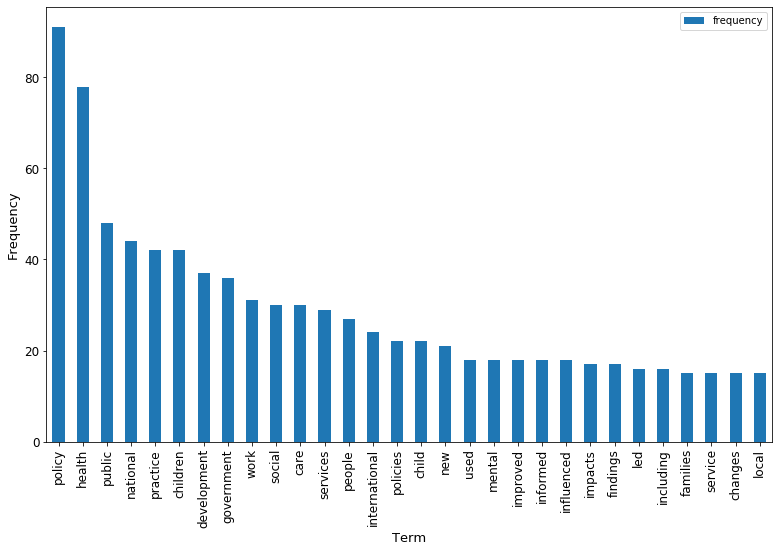

In [15]:
freq_words_df.iloc[0:max_items_to_show,:].plot(x='word', y='frequency', kind='bar', figsize=(13,8))
plt.xticks(rotation=90)
plt.xlabel("Term", size=13)
plt.ylabel("Frequency", size=13)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

### Most frequent terms in general sentences

Inspect the most used terms in sentences that do not neccesarily contain evidence of social impact

In [16]:
n_si_sentences = total_sentences[total_sentences['label']==0]['sentence']
n_fdist = FreqDist(word for n_si_sentence in n_si_sentences 
                        for word in n_si_sentence.split() if len(word) > 2 and word not in stopwords.words('english') and word not in word_black_list)
n_freq_words_df = pd.DataFrame(n_fdist.items(), columns=['word', 'frequency'])

In [17]:
n_freq_words_df.sort_values(by='frequency', ascending=False, inplace=True)

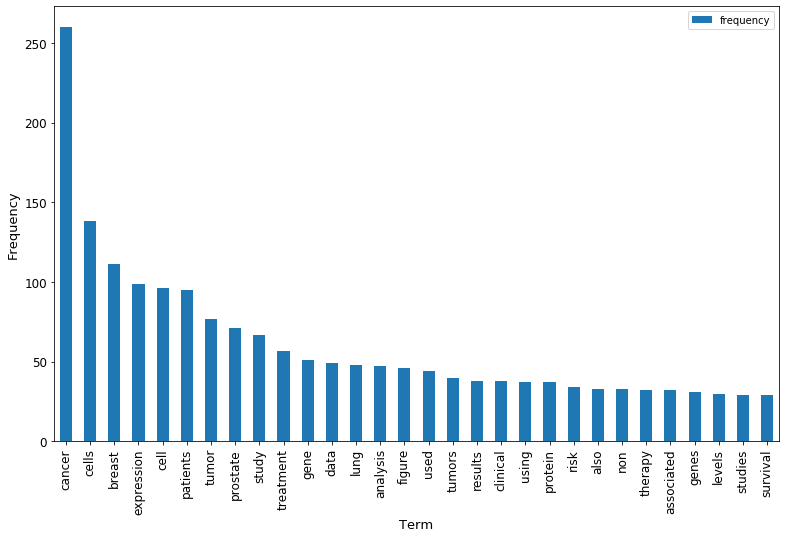

In [18]:
n_freq_words_df.iloc[0:max_items_to_show,:].plot(x='word', y='frequency', kind='bar', figsize=(13,8))
plt.xticks(rotation=90)
plt.xlabel("Term", size=13)
plt.ylabel("Frequency", size=13)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

From the figures above it can be seen there is little overlap between the most frequent terms in sentences with evidence of social impact (e.g., public policy, health, national, development) and the most frequent terms in the general sentences, which, as expected, are more related with medical and biological terminologies, such as cancer, cells, patients, tumor, or therapy. The low interception between the most frequent terms in the two datasets demonstrates the potential of the data to train machine learning classifier. 

## Prepare data

Data will be prepared using the following four combinations of the text processing tasks defined in `sentence_to_words`:
1. Sentence is tokenized and stop words as well as HTML elements are removed;
2. Sentence is tokenized, stop words and HTML elements are removed and stemming is applied;
3. Sentence is tokenized, stop words and HTML elements are removed and lemmatization is applied;
4. Sentence is tokenized, stop words and HTML elements are removed and stemming and lemmatization are applied.


In [19]:
data, labels = total_sentences['sentence'], total_sentences['label']

In [20]:
%%time
data_clean = [sentence_to_words(sentence) for sentence in data]
data_clean_with_steeming = [sentence_to_words(sentence, steeming=True) for sentence in data]
data_clean_with_lemmatization = [sentence_to_words(sentence, lemmatization=True) for sentence in data]
data_clean_with_steeming_lemmatization = [sentence_to_words(sentence, True, True) for sentence in data]

CPU times: user 18.1 s, sys: 1.22 s, total: 19.3 s
Wall time: 19.3 s


Save preprocess data into a dictionary to avoid carrying around the recently create variables

In [21]:
preprocess_data = {
    'clean': {'data': data_clean, 'labels': labels},
    'clean_steeming': {'data': data_clean_with_steeming, 'labels': labels},
    'clean_lemmatization': {'data': data_clean_with_lemmatization, 'labels': labels},
    'clean_steeming_lemmatization': {'data': data_clean_with_steeming_lemmatization, 'labels': labels}
}

Check a sample of the preprocess data

In [22]:
preprocess_data['clean']['data'][0]

['widely',
 'featured',
 'national',
 'press',
 'radio',
 'actively',
 'engaged',
 'members',
 'public',
 'primary',
 'scientific',
 'research',
 'including',
 'super',
 'engagers',
 'sent',
 'detailed',
 'records',
 'samples']

### Transform to Bag-of-Words Representation

Previously processed sentences are transformed here to a bag-of-words representation. Forty-five (45) combinations of transformations are employed.

Define transformation conditions

In [23]:
transformations = ['tc', 'tf', 'tfidf']
max_features=[100, 200, 400, 500, 800]
ngram_ranges=[(1,1),(1,2),(1,3)]
total_cycles = len(transformations)*len(max_features)*len(ngram_ranges)*len(preprocess_data)

In [24]:
transformed_txts = []

In [25]:
with tqdm(total=total_cycles, file=sys.stdout) as pbar:
    for transformation in transformations:        
        for max_feature in max_features:
            for ngram_range in ngram_ranges:
                for processing_task, data_dict in preprocess_data.items():
                    pbar.update(1)
                    data = data_dict['data']
                    transformed_data, vocabulary = extract_BoW_features(data, max_feature, transformation, ngram_range)
                    transformed_txts.append(
                        {
                            'transformation': transformation,
                            'max_features': max_feature,
                            'ngram_range': ngram_range,
                            'data': transformed_data,
                            'processing_task': processing_task,
                            'labels': data_dict['labels'],
                            'vocabulary': vocabulary
                        }
                    )

100%|██████████| 180/180 [00:16<00:00, 11.14it/s]


Let's do some sanity check

In [26]:
transformed_txts[0]

{'transformation': 'tc',
 'max_features': 100,
 'ngram_range': (1, 1),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 'processing_task': 'clean',
 'labels': 0       1
 1       1
 2       1
 3       1
 4       1
        ..
 1001    0
 1002    0
 1003    0
 1004    0
 1005    0
 Name: label, Length: 1006, dtype: int64,
 'vocabulary': {'national': 55,
  'public': 71,
  'research': 73,
  'including': 44,
  'samples': 78,
  'one': 60,
  'study': 85,
  'impact': 43,
  'policy': 66,
  'used': 96,
  'work': 99,
  'performed': 65,
  'international': 46,
  'using': 97,
  'people': 64,
  'uk': 94,
  'university': 95,
  'development': 22,
  'social': 82,
  'changes': 16,
  'non': 57,
  'within': 98,
  'data': 21,
  'services': 79,
  'treatment': 90,
  'first': 31,
  'time': 89,
  'based': 8,
  'specific': 83,
  'two': 93,
  '

In [27]:
assert len(transformed_txts[0]['data']) == len(transformed_txts[0]['labels'])

## Split data into train and test and save it

Iterate over the 180 combinations of text processings and transformations and for each combination hold out a fraction of data for testing the model and save the rest for training the model.

In [28]:
random_state = np.random.RandomState(1234)  # set a random seed for reproducibility purposes

In [32]:
with tqdm(total=total_cycles, file=sys.stdout) as pbar:
    for transformed_txt in transformed_txts:
        transformation = transformed_txt['transformation']
        max_features = str(transformed_txt['max_features'])
        ngram_range = str(transformed_txt['ngram_range'])
        processing_task = transformed_txt['processing_task']
        vocabulary = transformed_txt['vocabulary']
        data = pd.DataFrame({'sentence': list(transformed_txt['data']), 'label': transformed_txt['labels']})
        # select 20% of each class for testing
        test_label_1 = data[data['label']==1].sample(frac=0.2, random_state=random_state)
        test_label_0 = data[data['label']==0].sample(frac=0.2, random_state=random_state)        
        test_data = pd.concat([test_label_1, test_label_0], ignore_index=True)
        # take the rest for training
        test_indexes = list(test_label_1.index) + list(test_label_0.index)
        train_data = data[~data.index.isin(test_indexes)]
        # check if the number of rows in train and test are equal to the number of rows in data
        assert (train_data.shape[0]+test_data.shape[0]) == data.shape[0], 'Number of rows in train and test datasets should be equal to the numeber of rows in the entire dataset'
        # save data
        data_filename = f'data_{transformation}_{max_features}_{ngram_range}_{processing_task}.pkl'
        dict_data = dict(train_data=train_data, test_data=test_data, vocabulary=vocabulary)
        with open(os.path.join('data', 'train_test', data_filename), "wb") as f:
            joblib.dump(dict_data, f)    
        pbar.update(1)

100%|██████████| 180/180 [00:13<00:00, 13.57it/s]


## Build ML model

Here we build the machine learning classifier. The decision on the algorithms to be used was based on algorithms that have been reported to perform well on unbalanced, small, and textual datasets, which is our case. Therefore, we try the following algorithms: Naive-Bayes, Support Vector Machine, Logistic Regression, Random Forest, and Gradient Boosting.

In bulding the model we proceed as following:
1. Compare the performance of the choosen algorithms by training them in each of the 180 different training sets;
2. Choose the best performing model for each algorithm;
3. Perform hyper-parameters optimization for the best models, except Naive-Bayes. GridSearch is used for SVM and Logistic Regression while RandomGridSearch with 100 iterations is employed for Random Forest and Gradient Boosting;
4. Plot learning curves for the best models to analyze the overfitting effect on the training set and the effect of the training size on the performance metric;
5. Select the model that best generalize the prediction.

Models are trained using the cross-validation approach. The performance metric to be optimized is **`recall`** because, in spite of over-identifying sentences that might not contain evidence of social impact and even when more sentences mean an overload of work for evaluators, the aim is to avoid losing sentences that can potentially contain evidence of impact and thus might be deciding in understanding the social impact of the research.

In [33]:
def get_classifier(algorithm_name):
    if algorithm_name == 'NB':
        classifier = GaussianNB()
    elif algorithm_name == 'SVM':
        classifier = SVC(random_state=random_state)   
    elif algorithm_name == 'LR':
        classifier = LogisticRegression(random_state=random_state)
    elif algorithm_name == 'RF':        
        classifier = RandomForestClassifier(random_state=random_state)
    elif algorithm_name == 'GB':
        classifier = GradientBoostingClassifier(random_state=random_state)
    else:
        print("Unknown algorithm: {0}",format(algorithm_name))
    return classifier

In [34]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
algorithms = ['NB', 'SVM', 'LR', 'RF', 'GB']
total_cycles *= len(algorithms)

In [41]:
with open('./data/train_test/data_tc_100_(1, 1)_clean_lemmatization.pkl', "rb") as f:
    data = joblib.load(f)
train_data = data['train_data']
#train_data['sentence'].values

In [44]:
outputs = []
with tqdm(total=total_cycles, file=sys.stdout) as pbar:
    data_path = os.path.join('data', 'train_test', '*.pkl')
    files = glob.glob(data_path)            
    for file in files:
        with open(file, "rb") as f:
            data = joblib.load(f)
        train_data = data['train_data']
        X_train = list(train_data['sentence'].values)
        y_train = train_data['label'].values
        for algorithm in algorithms:            
            classifier = get_classifier(algorithm)
            scores = cross_val_score(classifier, X_train, y=y_train, scoring="recall", cv=kfold, n_jobs=-1)
            outputs.append(
                {
                    'algorithm': algorithm,
                    'train_filename': file,                
                    'metrics': scores,
                }
            )
            pbar.update(1)

100%|██████████| 900/900 [11:38<00:00,  1.29it/s]


In [45]:
output_df = pd.DataFrame(columns=['algorithm', 'train_data_file', 'mean_recall'])
for output in outputs:
    row = {
        'algorithm': output['algorithm'],
        'train_data_file': output['train_filename'],
        'mean_recall': round(output['metrics'].mean(), 2),
        'std_recall': round(output['metrics'].std(), 2)
    }
    output_df = output_df.append(row, ignore_index=True)

In [46]:
output_df.head()

,algorithm,train_data_file,mean_recall,std_recall
0,NB,"data/train_test/data_tf_800_(1, 3)_clean.pkl",0.95,0.07
1,SVM,"data/train_test/data_tf_800_(1, 3)_clean.pkl",0.00,0.00
2,LR,"data/train_test/data_tf_800_(1, 3)_clean.pkl",0.79,0.12
3,RF,"data/train_test/data_tf_800_(1, 3)_clean.pkl",0.87,0.08
4,GB,"data/train_test/data_tf_800_(1, 3)_clean.pkl",0.74,0.10


Save training results to a csv

In [47]:
experiment_dir = 'experiments'  # directory to store experiments
os.makedirs(experiment_dir, exist_ok=True)  # ensure the directory exists
output_df.to_csv(experiment_dir+'/e_28052020.csv', index=False)

### Compare the best models of each type

In [48]:
mean_best_models, std_best_models = [], []
for algorithm in algorithms:
    best_model = output_df[output_df['algorithm']==algorithm].sort_values(by=['mean_recall', 'std_recall'], ascending=False).head(1)
    mean_recall = best_model['mean_recall'].values[0]
    std_recall = best_model['std_recall'].values[0]
    mean_best_models.append(mean_recall)    
    std_best_models.append(std_recall)
    print(f'Algorithm: {algorithm}, Mean Recall: {mean_recall}, Std. Recall: {std_recall}')

Algorithm: NB, Mean Recall: 1.0, Std. Recall: 0.0
Algorithm: SVM, Mean Recall: 0.77, Std. Recall: 0.14
Algorithm: LR, Mean Recall: 0.91, Std. Recall: 0.06
Algorithm: RF, Mean Recall: 0.94, Std. Recall: 0.05
Algorithm: GB, Mean Recall: 0.91, Std. Recall: 0.09


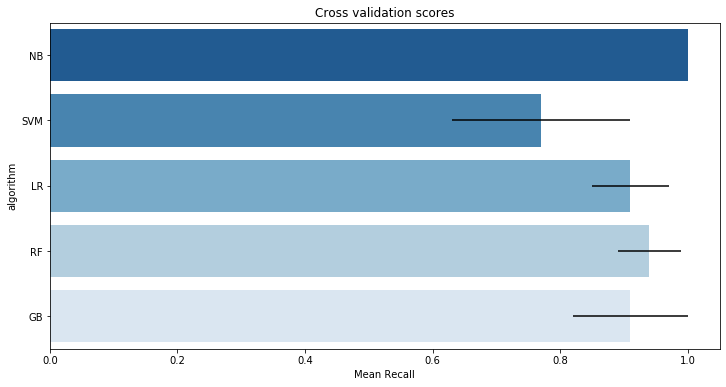

In [49]:
cv_res = pd.DataFrame({
    'cross_val_means': mean_best_models,
    'cross_val_std': std_best_models,
    'algorithm': algorithms
})
plt.figure(figsize=(12,6))
g = sns.barplot('cross_val_means', 'algorithm', data = cv_res, palette='Blues_r', orient = "h", **{'xerr':std_best_models})
g.set_xlabel('Mean Recall')
g = g.set_title('Cross validation scores')

### Perform hyper-parameters optimization

#### Support Vector Machine (SVM)

In [51]:
# get train data
best_model = output_df[output_df['algorithm']=='SVM'].sort_values(by=['mean_recall', 'std_recall'], ascending=False).head(1)
with open(best_model['train_data_file'].values[0], "rb") as f:
    data = joblib.load(f)
train_data = data['train_data']
X_train_svm = list(train_data['sentence'].values)
y_train_svm = train_data['label'].values

In [52]:
# define parameters
# https://towardsdatascience.com/svm-hyper-parameter-tuning-using-gridsearchcv-49c0bc55ce29
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001, 'scale'],
              'kernel': ['linear','rbf', 'poly']
              }
# run grid search
gs_svm = GridSearchCV(SVC(), param_grid=param_grid, cv=kfold, scoring="recall", n_jobs=4, verbose=1)
gs_svm.fit(X_train_svm, y_train_svm)
svm_best = gs_svm.best_estimator_
gs_svm.best_score_

Fitting 10 folds for each of 75 candidates, totalling 750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   16.1s
[Parallel(n_jobs=4)]: Done 750 out of 750 | elapsed:   26.8s finished
/home/Life/jsaldiva/.conda/envs/impactenv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.9211367445528936

**Diagnosis**. In this model the training score is at maximum regardless of the training size, which is signal of overfitting. The large gap between training and validation confirms a high-variance scenario.

#### Logistic Regression (LR)

In [55]:
# get train data
best_model = output_df[output_df['algorithm']=='LR'].sort_values(by=['mean_recall', 'std_recall'], ascending=False).head(1)
with open(best_model['train_data_file'].values[0], "rb") as f:
    data = joblib.load(f)
train_data = data['train_data']
X_train_lr = list(train_data['sentence'].values)
y_train_lr = train_data['label'].values

In [56]:
# define parameters
# https://chrisalbon.com/machine_learning/model_selection/hyperparameter_tuning_using_grid_search
param_grid = {'penalty': ['l1', 'l2'],
              'C': np.logspace(0, 4, 10)
              }
# run grid search
gs_lr = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=kfold, scoring="recall", n_jobs=6, verbose=1)
gs_lr.fit(X_train_lr, y_train_lr)
lr_best = gs_lr.best_estimator_
gs_lr.best_score_

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:    3.3s
[Parallel(n_jobs=6)]: Done 200 out of 200 | elapsed:    5.5s finished
/home/Life/jsaldiva/.conda/envs/impactenv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/Life/jsaldiva/.conda/envs/impactenv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9202247855664005

#### Random Forest (RF)

In [53]:
# get train data
best_model = output_df[output_df['algorithm']=='RF'].sort_values(by=['mean_recall', 'std_recall'], ascending=False).head(1)
with open(best_model['train_data_file'].values[0], "rb") as f:
    data = joblib.load(f)
train_data = data['train_data']
X_train_rf = list(train_data['sentence'].values)
y_train_rf = train_data['label'].values

In [54]:
# define parameters
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 7, 10]
min_samples_leaf = [1, 2, 3]
bootstrap = [True, False]
param_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}
# run grid search
gs_rf = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_grid, n_iter=100, cv=kfold, scoring="recall", n_jobs=6, verbose=1)
gs_rf.fit(X_train_rf, y_train_rf)
rf_best = gs_rf.best_estimator_
gs_rf.best_score_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   14.3s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   44.6s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed:  3.7min finished


0.9654796411318151

#### Gradient Boosting (GB)

In [57]:
# get train data
best_model = output_df[output_df['algorithm']=='GB'].sort_values(by=['mean_recall', 'std_recall'], ascending=False).head(1)
with open(best_model['train_data_file'].values[0], "rb") as f:
    data = joblib.load(f)
train_data = data['train_data']
X_train_gb = list(train_data['sentence'].values)
y_train_gb = train_data['label'].values

In [58]:
# define parameters
# https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling/notebook#Titanic-Top-4%-with-ensemble-modeling
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 7, 10]
min_samples_leaf = [1, 2, 3]
loss = ['deviance']
learning_rate = [0.1, 0.05, 0.01]
param_grid = {'loss' : loss,
              'n_estimators' : n_estimators,
              'learning_rate': learning_rate,
              'max_depth': max_depth,
              'min_samples_leaf': min_samples_leaf,
              'max_features': max_features,
              'min_samples_split': min_samples_split
              }
# run grid search
gs_gb = RandomizedSearchCV(GradientBoostingClassifier(), param_distributions=param_grid, n_iter=100, cv=kfold, scoring="recall", n_jobs=6, verbose=1)
gs_gb.fit(X_train_gb, y_train_gb)
gb_best = gs_gb.best_estimator_
gs_gb.best_score_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   32.6s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  6.9min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed: 12.3min
[Parallel(n_jobs=6)]: Done 1000 out of 1000 | elapsed: 15.8min finished
/home/Life/jsaldiva/.conda/envs/impactenv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.9472503204180222

### Plot learning curve

In [59]:
# Taken from 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), shuffle=False):
    """Generate a simple plot of the test and training learning curve"""
    
    plt.figure(figsize=(12,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, n_jobs=n_jobs, cv=cv, train_sizes=train_sizes, shuffle=shuffle)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#### **Naive-Bayes (NB)**

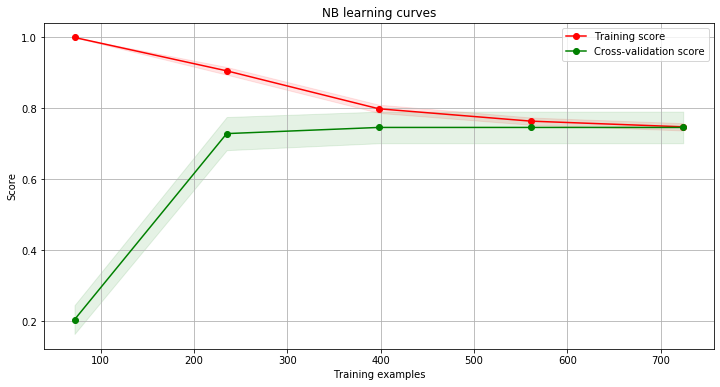

In [60]:
best_model = output_df[output_df['algorithm']=='NB'].sort_values(by=['mean_recall', 'std_recall'], ascending=False).head(1)
with open(best_model['train_data_file'].values[0], "rb") as f:
    data = joblib.load(f)
train_data = data['train_data']
X_train_nb = list(train_data['sentence'].values)
y_train_nb = train_data['label'].values
g = plot_learning_curve(GaussianNB(), "NB learning curves", X_train_nb, y_train_nb, cv=kfold)
g.show()

**Diagnosis**. Learning curves in NB model shows that training scores decreases as the size of the training set increases. This indicates that the model does not overfitting on training data (low variance). On the contrary, the validation curve increases as more training examples are available, which tells us that the model is correctly learning from the training examples. The small gap between training and validation is also a sign of low variance. Both curves converge at some point, which is also a good indicator of correct learning. However, errors in both training and validation are around 20%, which means that the model is not able to correctly capture 20 out of 100 sentences of social impact. Given the size and unbalanced nature of the data, this might be a tolerable error.

#### **Support Vector Machine (SVM)**

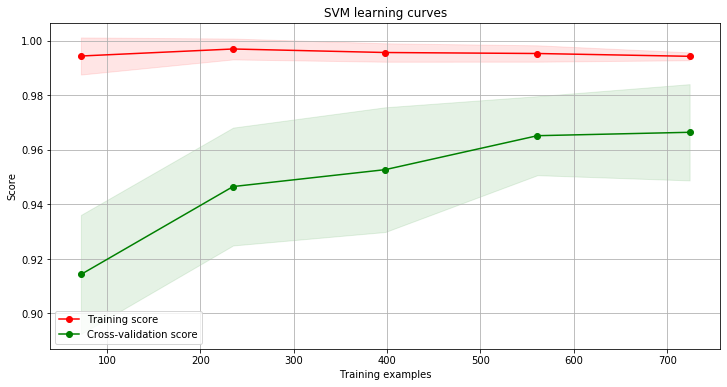

In [61]:
g = plot_learning_curve(svm_best, "SVM learning curves", X_train_svm, y_train_svm, cv=kfold, shuffle=True)
g.show()

**Diagnosis**. Training curve keep constant independently of the training size, which indicates an overfitting problem. Also, the large gap between training and validation is a sign of high-variance.

#### **Logistic Regression (LR)**

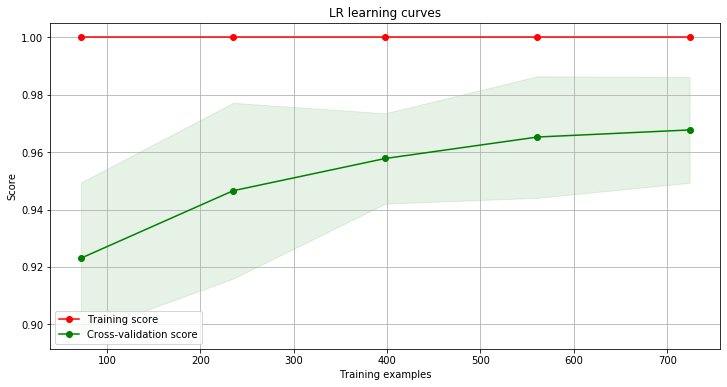

In [62]:
g = plot_learning_curve(lr_best, "LR learning curves", X_train_lr, y_train_lr, cv=kfold, shuffle=True)
g.show()

**Diagnosis**. In this model the training score is at maximum regardless of the training size, which is signal of overfitting. The large gap between training and validation confirms a high-variance scenario.

#### **Random Forest (RF)**

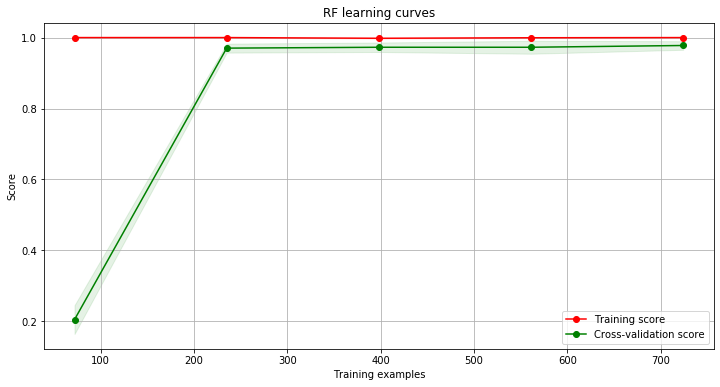

In [63]:
g = plot_learning_curve(rf_best, "RF learning curves", X_train_rf, y_train_rf, cv=kfold)
g.show()

**Diagnosis**. In this model the training score is at maximum regardless of the training size, which is signal of overfitting.

#### **Gradient Boosting (GB)**

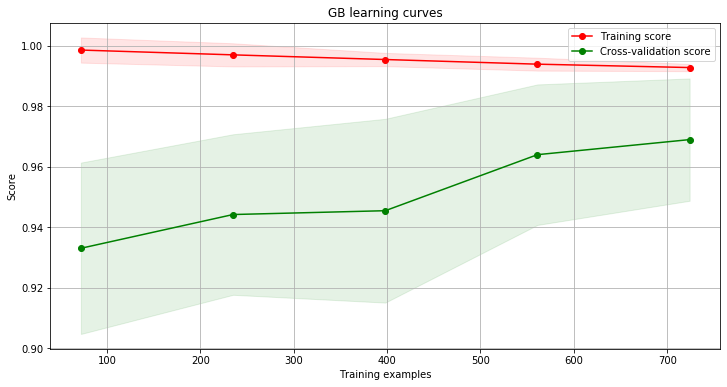

In [64]:
g = plot_learning_curve(gb_best, "GB learning curves", X_train_gb, y_train_gb, cv=kfold, shuffle=True)
g.show()

**Diagnosis**. In this model the training score is at maximum regardless of the training size, which is signal of overfitting. The large gap between training and validation confirms a high-variance scenario.

### Select model

Based on the previous diagnosis, Naive-Bayes model is selected as the best option to conduct the classification task. Next, an NB model will be trained on the data that was found to be optimal for a NB model.

In [65]:
nb_classifier = GaussianNB()
recall_scores = []
data = np.array(X_train_nb)
labels = np.array(y_train_nb)
for train_index, test_index in kfold.split(data):
    kf_X_train, kf_X_test = data[train_index], data[test_index]
    kf_y_train, kf_y_test = labels[train_index], labels[test_index]        
    nb_classifier.fit(kf_X_train, kf_y_train)
    y_pred = nb_classifier.predict(kf_X_test)
    recall_scores.append(metrics.recall_score(kf_y_test, y_pred))

In [66]:
print(f'Mean of recall scores on training: {round(np.array(recall_scores).mean(),2)}')

Mean of recall scores on training: 1.0


#### Save Model

In [67]:
models_dir = 'models'  # directory to store models
os.makedirs(models_dir, exist_ok=True)  # ensure the directory exists
train_fn = output_df[output_df['algorithm']=='NB'].sort_values(by=['mean_recall', 'std_recall'], ascending=False).head(1)['train_data_file'].values[0]
text_processing_tasks = '_'.join(train_fn.split('_')[2:]).split('.')[0]
model_name = '{}-{}.joblib'.format('naive-bayes',text_processing_tasks)
model_file_name = os.path.join(models_dir,model_name)
joblib.dump(nb_classifier, model_file_name)

['models/naive-bayes-tc_100_(1, 3)_clean_steeming.joblib']

## Evaluate model

### Load model

In [69]:
model = joblib.load('./models/naive-bayes-tc_100_(1, 3)_clean_steeming.joblib')

### Load test data

In [70]:
with open('./data/train_test/data_tc_100_(1, 3)_clean_steeming.pkl', 'rb') as f:
    data = joblib.load(f)
test_data = data['test_data']

In [71]:
X_test = list(test_data['sentence'].values)
y_test = test_data['label'].values

### Make predictions

In [72]:
pred = model.predict(X_test)

### Compute performance metrics

In [73]:
print(f'Recall: {round(metrics.recall_score(y_test, pred),2)}')

Recall: 0.95
